# Recursive Partitioning Guide

Author: Sam Kerns, M.A.

Date: 1/21/2022

## Why Recursive Partitioning?

### Logistic Regression Has Its Limits

One of the most common problems in data science is predicting an outcome based on a number of independent variables. For example, we might be interested in what proportion of students reach benchmark reading scores by fourth grade depending on things like curriculum, hours of instruction, etc.

The most typical approach to answering these types of questions is simple regression techniques. Specifically, logistic regression techniques are perhaps the most common and simple method for evaluating variables influence on a dichotomous outcome. However, logistic regression carries with in a number of assumptions that can sometimes prevent confidence in statistical results.

### The Problem of Multicollinearity

In many datasets related to human behavior, multicollinearity is virtually impossible to avoid. Multicollinearity is a statistical phenomenon that occurs when independent variables used to predict a dependent variable are highly correlated to one another (or even causally related). Let's illustrate a practical example of multicollinearity by carrying on the example above and assume that we want to evaluate if students are meeting testing benchmarks. Let's say our independent variables are Socioeconomic Status, Grade, Hours of Instruction, Curriculum Selected, and Teacher Years of Experience.

![multicollinearity](https://memegenerator.net/img/instances/62025447.jpg)

At first blush, these variables may not appear to be directly related to one another. However, some of these variables could be causally-related to one another. Hours of Instruction in reading may be grade-dependent (where earlier grades receive more instruction than later grades) or Socioeconomic status may be related to Teacher Years of Experience (where more tenured teachers in a given geographic area flock to schools of higher or lower community wealth).

When multicollinearity occurs in a logistic regression model, the results become unreliable. Sometimes an important interaction between IVs can be hidden, or the model's accuracy can be inappropriately inflated.

### The Problem of Sample Size

In statistics, increasing sample size (assuming the sampling technique is sound) is almost always a good move. However, in logistic regression, it's a necessity. Results become increasingly reliable in logistic regression as sample size increases. Additionally, if you have an outcome that is very UNLIKELY, perhaps the above-benchmark performance in an underperforming school, your minimum sample size must be even larger to capture a sufficiently saturated dataset that includes enough individuals with these low-incidence outcomes to be reliable.

![samplesize](https://media.makeameme.org/created/your-sample-sizes-fc327a.jpg)

### The Problem of Missing Data

Missing data are often problematic for logistic regression models, especially when missingness is non-random (which is often the case). Rubin (1976) classified missing data into three categories: Missing Completely at Random (MCAR), Missing at Random (MAR), and Missing Not at Random (MNAR).

For a sufficiently large dataset, there are little concerns to be had with data that is MCAR or MAR. However, when the data are MNAR, we may have an analytics issue. What if the data are missing as a function of a third factor (measured or unmeasured). However do we contend with this? We could impute the data, but this may only serve to reinforce the effect of the data that are present rather than accurately inferring the value of the variables for which we are performing the imputation.

![missing](https://pbs.twimg.com/media/D0kVZPPX0AA6xgd.png)

For example, let's supposed that we're looking to impute Teacher Years of Experience with the mean of the data present for that variable, but the teachers not reporting their years of experience are almost solely teachers with a small number of years (perhaps they are self-conscious about their lack of experience). Imputing the mean will now OVER-represent larger values for Teacher Years of Experience. Even nuanced imputation methods like [Multiple Imputation by Chained Equations (MICE)](https://www.jstatsoft.org/article/view/v045i03) will still struggle if presented with a non-random pattern of missingness that is not well-predicted by other factors in the dataset.

### Enter Recursive Partitioning

Recursive partitioning, while not a silver bullet, can help address some of these issues. Essentially, recursive partitioning is a decision tree model which takes binary IVs (or creates them from continuous IVs) and iterates over a number of IV combinations to create a probabilistic estimation of the DV in question.

![regressiontrees](https://miro.medium.com/max/1400/1*WerHJ14JQAd3j8ASaVjAhw.jpeg)

In the remainder of this markdown document, we're going to take a look at a toy dataset and use `rpart` package to create a decision tree for our DV. As we go, we'll talk about the strengths and weaknesses of this approach and will provide comparison to logistic regression where relevant. However, there are a few important elements that you should evaluate prior to choosing this method. Take a look below to see if recursive partitioning is right for your project.

**Recursive Partitioning may be a good choice for you if:**

1.  Your dependent variable is binary or ordinal in nature,

2.  You have a number of potentially related independent variables of any type,

3.  You have missing data that you suspect is MNAR,

4.  You are interested in creating an accuracy estimation (i.e. when IV1 == x and IV2 \> y, there is a xx% chance that the DV == z),

5.  You want to leverage a machine learning model that is transparent, simple, and efficient,

6.  You are not worried about the potential for overfitting in your data - recursive partitioning has been shown to be more likely to overfit data that ensemble methods such as random forests. If you do suspect overfitting will cause major issues for your use-case, but the rest of these bullets sound compelling, check out the `ranger` package for random forests in R.

In [1]:
##First, let's load up the cars dataset from Kaggle: https://www.kaggle.com/abineshkumark/carsdata and peek at the data

##Loading up the Hadleyverse
library(tidyverse)

##Reading in the Data
cars <- read.csv("../input/carsdata/cars.csv")
head(cars)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



,mpg,cylinders,cubicinches,hp,weightlbs,time.to.60,year,brand
,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,14.0,8,350,165,4209,12,1972,US.
2,31.9,4,89,71,1925,14,1980,Europe.
3,17.0,8,302,140,3449,11,1971,US.
4,15.0,8,400,150,3761,10,1971,US.
5,30.5,4,98,63,2051,17,1978,US.
6,23.0,8,350,125,3900,17,1980,US.


## Preparing the Data

The first thing that we'll need to do for this tutorial is define our IVs and DV. Let's say that, like me, you like to drive your car fast. So you decide that you want a car that does 0-60 in less than 15 seconds (this is still slow by modern standards, but, hey, it was the 70s!). So we'll make a 0-60 time above or below 15 seconds our DV (above 15+ seconds is 0 and <15 seconds is 1). Let's go ahead and make that modification to the dataset now.

In [2]:
##Using case_when to create our new variable: fast
cars <- cars %>%
  mutate(fast = case_when(time.to.60 < 15 ~ 1,
                          time.to.60 >= 15 ~ 0))

##Let's see how many of our cars are fast
as.data.frame(table(cars$fast))

Var1,Freq
<fct>,<int>
0,172
1,89


That's not a ton of cars. Luckily, recursive partitioning can handle smaller sample sizes with relative ease. To ensure that our data are as accurate as possible, let's take a subsample of these data on which we will train the ML model and then compare our results to the real data. We'll call the set.seed and sample functions to achieve this.

In [3]:
##Creating proportion (70%) of the data to use for training
ss <- floor(0.7 * nrow(cars))

##Setting seed to make the partition reproducible
set.seed(500)
train_ss <- sample(seq_len(nrow(cars)), size = ss)

##Splitting the data based on the partition created above
cars_train <- cars[train_ss, ]
cars_test <- cars[-train_ss, ]

Ok, cool. Now we've randomly distributed our data over a training and testing sample, with 70% of the data occupying the training set and 30% occupying the testing set. These ratios can be modified based on your use case. Typically, the larger the portion of the sample on which you train, the lower the likelihood of overfitting (unless your sample are homogeneous). With smaller data sets, you'll need to make a judgment call recognizing that, as in this example, if the data are randomly distributed, only 70% of the 89 fast cars will be included in the training data, which is only 62 examples (not a lot). Even scarier will be the precision that will be required of the model to find the remaining 17 fast cars in the test set. Let's see how we do!

## Selecting our Predictors (IVs)

Now that we've split up the data, let's decide what we want to use as IVs. We could, obviously, just feed the model EVERY variable in our dataset. However, that's a pretty blunt force approach and may actually complicate or reduce the accuracy of the prediction. Instead, let's try to think about MODELING 0-60 time and focusing on only the MOST relevant data.

As a bit of a gear-head, I can help guide us here. Typically there are a few MOST important elements to 0-60 time: cylinders, displacement (cubicinches in this dataset), and weight. Additionally, cars have been getting faster over time, so year probably matters and mpg is usually inversely related to 0-60 time. So my recommendation is that we use the following variables: `mpg`, `cylinders`, `cubicinches`, `weightlbs`, and `year` as IVs. Wait, why not horsepower? Well, horsepower is usually a function of engine size (number of cylinders and displacement), so we don't really need that as well.

![horsepower](https://i.pinimg.com/originals/0f/04/02/0f04022bb030df503371289526e7feec.jpg)

But wait...aren't cylinder number and displacement related? Well, yes. That being said, there are some larger displacement engines with a smaller number of cylinders and vice versa. So yes, there probably is a relationship between these two variables, but probably not so much that it's a guarantee that one is a proxy for the other (in the way that their combination is a proxy for horsepower). This is a spot where multicollinearity would like cause issues in a logistic regression model...more on this to come...

Now, let's go ahead and drop the variables in our training dataset in which we are not interested:

In [4]:
##Retaining only the target variables
cars_train <- cars_train %>%
  subset(., select = -c(hp, time.to.60, brand))

## Statistics Time!

Up to this point, there's really nothing that we've done that would be substantively different from a logistic regression model. As a result, let's go ahead and run a GLM to see what happens!

In [5]:
##Running the glm and evaluating the results
glm <- glm(fast ~ .,
           data = cars_train,
           family = binomial, 
           na.action = na.omit)

#Creating table
summary(glm)


Call:
glm(formula = fast ~ ., family = binomial, data = cars_train, 
    na.action = na.omit)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6332  -0.5997  -0.4118   0.6491   2.4311  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)   
(Intercept) -44.471675 144.984365  -0.307  0.75905   
mpg          -0.070122   0.065009  -1.079  0.28074   
cylinders     0.022073   0.356091   0.062  0.95057   
cubicinches   0.020955   0.008010   2.616  0.00889 **
weightlbs    -0.001508   0.000752  -2.005  0.04491 * 
year          0.022971   0.074116   0.310  0.75661   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 230.51  on 179  degrees of freedom
Residual deviance: 160.78  on 174  degrees of freedom
  (2 observations deleted due to missingness)
AIC: 172.78

Number of Fisher Scoring iterations: 5


So far, this looks like we're on to something. While `mpg`, `cylinders`, and `year` did not seem to have much impact, `cubicinches` and `weightlbs` demonstrated statistical significance.

Now, in this case, we decided to just drop any rows with missing data (further reducing our sample size). But wait...we didn't check for multicollinearity. Should probably do that. We'll use `car::vif` to evaluate multicollinearity. We're looking for values UNDER 5 or else we're going to be quite skeptical of the results we just got above.

In [6]:
##Checking on Multicollinearity
library(car)

as.data.frame(car::vif(glm))

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode


The following object is masked from ‘package:purrr’:

    some




,car::vif(glm)
,<dbl>
mpg,4.848877
cylinders,9.002046
cubicinches,15.148926
weightlbs,9.499400
year,1.692238


**Aw nuts!** As anticipated, we're finding multicollinearity in `cylinders` and `cubicinches`. We're also seeing multicollinearity in `weightlbs`, which makes sense given that larger values for cylinders and cubic inches are related to weight. So yes, it's nice that we got some statistically significant results, but now we're really concerned about the accuracy. If this was all you had in the pocket, you'd have to either make major changes to your model or you'd need to throw in the towel. Luckily, we've got recursive partitioning to fall back on!

## Machine Learning Alternative

Finally, it's time to do some machine learning!

![ML](https://media.makeameme.org/created/machine-learning-machine-884d19c7bd.jpg)

We've discovered that our typical glm approach isn't going to work because there's multicollinearity in 3 of our 5 IVs. Let's give recursive partitioning via the `rpart` package a try and see if we can still manage to find some interesting information despite this issue.

In [7]:
##Running the recursive partitioning model, visualizing tree
library(rpart, quietly = T)
library(rpart.plot, quietly = T)

rpart <- rpart(fast ~ .,                     #Formula for the rpart algorithm
               data = cars_train,            #Dataset for variables
               na.action = na.rpart)         #Accommodate missingness

##This code produces the image below, but is being commented out for formatting purposes
#prp(rpart, 
    #fallen.leaves = T,                       #Cleaning up the looks
    #type = 0,                                #Showing probabilities at end of node
    #yesno = 2,                               #Including y/n at each branch
    #extra = 101,                             #Showing n/% of sample per node
    #main = "Probability of Fast Car",        #Titling graph
    #shadow.col = "gray",                     #Adding shadow to the nodes
    #border.col = "green")                    #Adding fill color to the nodes

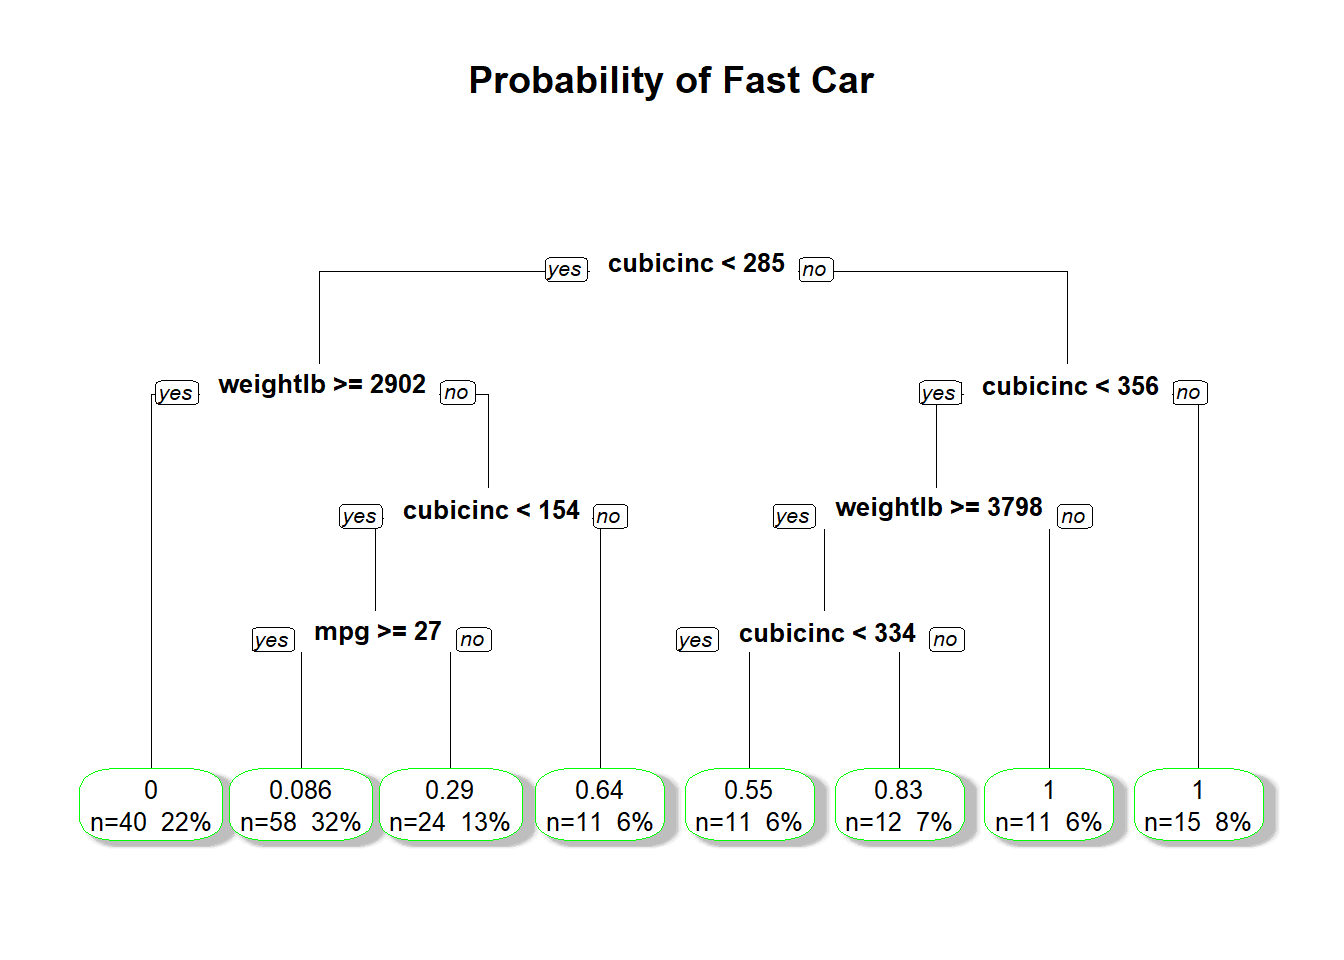

Take a look at this graph. After iterating over the data numerous times, this algorithm decided that this path was the most efficient path for determining the probability that a car has a 0-60 time above or below 15 seconds. Interestingly, where the glm model did not indicate any meaningful relationship of mpg, this model shows that, for cars with lower displacement, lower mpg could also indicate a higher probability of a fast 0-60 time!

And what about that `na.action = na.rpart` line? What's happening there? Well, the recursive partitioning model is dropping only cases where the DV is absent or ALL the IVs are absent. For those where some missing data is present, the model will attempt to evaluate the probability with only the IVs available. The advantage of this approach is that we don't impute data that might be inaccurate and unduly inflate the impact of our IVs while still evaluating all the rows of data. In logistic regression, we would be forced to either impute the values or drop the cases with any missingness. For large datasets with high proportions of missingness, this provides a "path of least resistance" approach to handling missing data that will maintain usefulness of the outcomes!

Now, let's go ahead and apply these data to our test set and see how accurate we are!

In [8]:
##Adding fitted values to the test set
cars_test$fit_vals <- predict(object = rpart, 
                              newdata = cars_test, 
                              level = 0.99, 
                              na.action = na.rpart)

##Mutating the values to 1 and 0 based on .5 cut score for 0/1 split
cars_test <- cars_test %>%
  mutate(fit_vals = case_when(fit_vals < .5 ~ 0,
                              fit_vals >= .5 ~ 1))

##Calculating the proportion of matches
cars_test %>%
        summarise(Hit = (length(which(fast == fit_vals))/79)*100,
                  Miss = (length(which(fast != fit_vals))/79)*100)

Hit,Miss
<dbl>,<dbl>
86.07595,13.92405


**Look at that!** **86% accuracy in predicting whether or not a car will be fast!** That's pretty good, especially given this small sample size! Additionally, it's pretty easy to interpret these results and to make some actionable recommendations to the car buyer in your life. With a individual-level dataset, we're often working on row numbers 10x this size or greater. The larger these datasets, the stronger the predictive accuracy is likely to become.

Finally, if you think about the process of providing these results to the client, you can always look at the results in-depth (`use summary(rpart)`), but the visualization produced in this case is easy to follow and may allow clients to make statistically informed decisions in a relatively straightforward manner. Want your car to be faster? Make sure you have more cubic inches in your engine or bring down the weight. Don't worry so much about the number of cylinders. One can imagine how helpful this would be if one were trying to determine which curriculum to choose, or which students are least likely to meet testing benchmarks and require support as a result.